In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 1
price = 200
iteration = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Medium Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

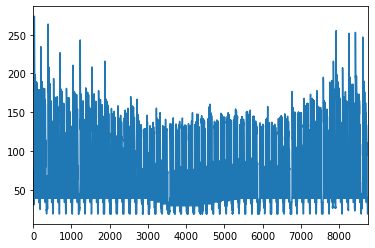

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 29,169.86
273.7716055773879


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 1,661 m²
Roof area is up 33 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.809628486633301 sec


0.0


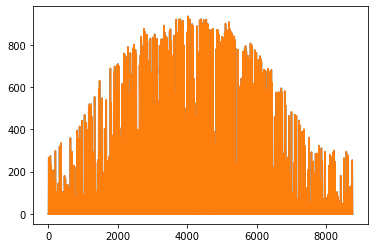

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


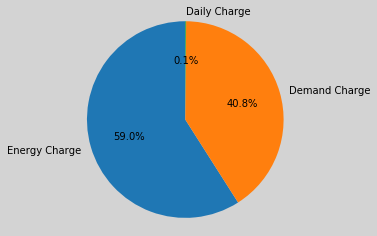

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

695621.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    29169.85
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         52160.4
Aug         56563.1
Dec         69736.5
Feb         57584.1
Jan         71584.2
Jul         51790.7
Jun         50497.1
Mar         62938.7
May         50835.5
Nov         63932.9
Oct         57272.7
Sep         50724.4
monthly_import    695620.3
dtype: float64
695621.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (105, 170, 185, 11, 51, 21, 0.25, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.361124753952026 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


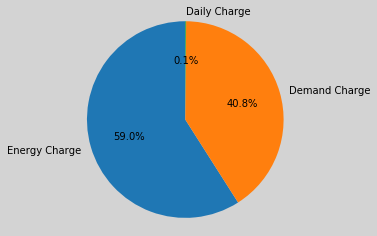

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (200, 150, 160, 31, 56, 11, 0.3, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


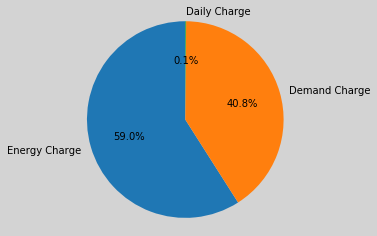

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (220, 130, 140, 6, 26, 36, 0.7, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


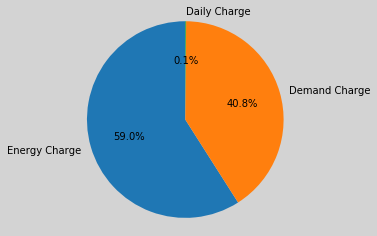

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 135, 170, 41, 31, 21, 0.8999999999999999, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


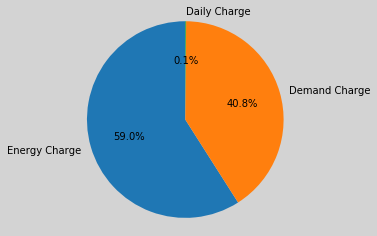

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 230, 195, 56, 16, 16, 0.39999999999999997, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


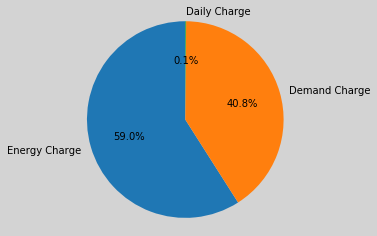

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 120, 140, 36, 36, 36, 0.3, 0.7, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


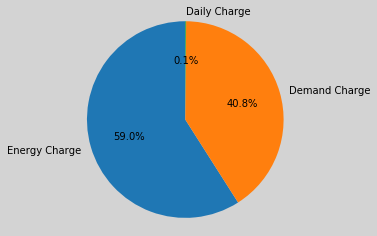

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 215, 180, 51, 26, 11, 0.39999999999999997, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


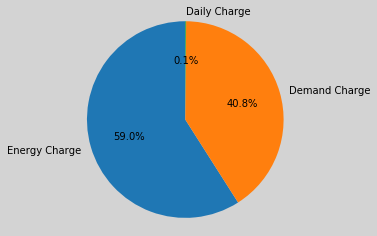

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (255, 125, 95, 36, 46, 56, 0.7, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.933297395706177 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


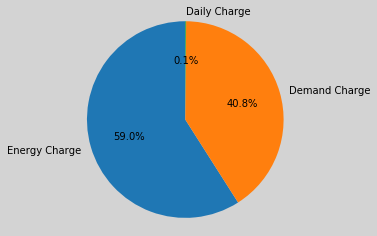

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 120, 255, 11, 31, 26, 0.5999999999999999, 0.25, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.988916873931885 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


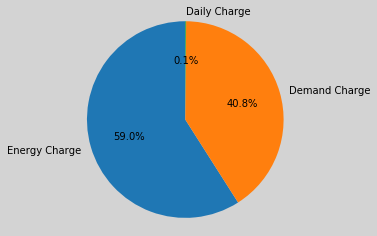

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 250, 265, 56, 46, 6, 0.3, 0.5999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


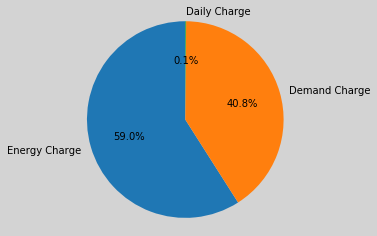

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 225, 110, 26, 41, 26, 0.7499999999999998, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


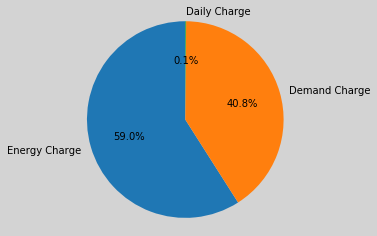

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 100, 260, 51, 21, 41, 0.25, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


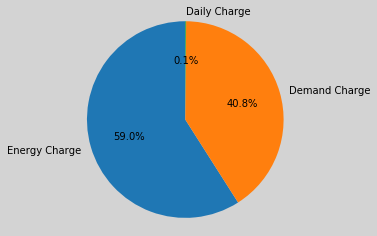

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 135, 235, 31, 26, 11, 0.6499999999999999, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.957284450531006 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


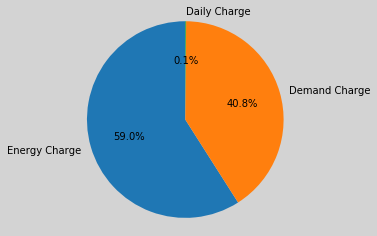

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 160, 135, 46, 56, 26, 0.3, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.688471794128418 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


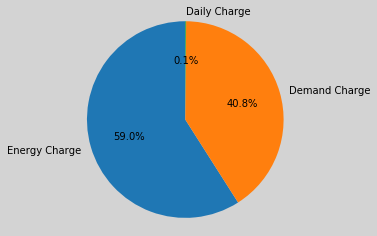

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (195, 155, 190, 36, 56, 46, 0.7, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


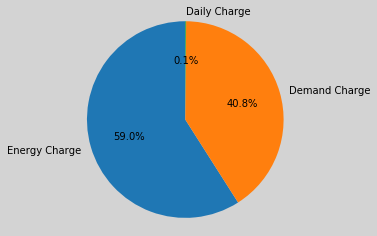

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 120, 225, 26, 56, 16, 0.3, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


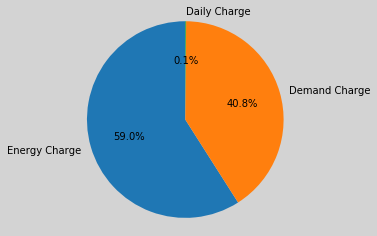

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 160, 210, 46, 26, 51, 0.7999999999999998, 0.7499999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 19.988279581069946 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  20s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


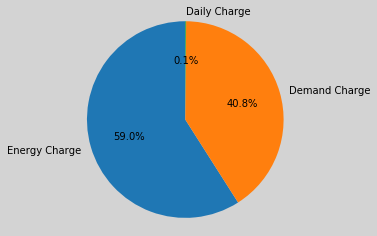

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 260, 195, 41, 51, 21, 0.8999999999999999, 0.7499999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.98136043548584 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


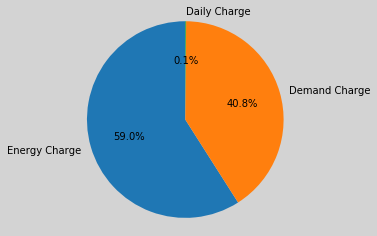

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 100, 250, 21, 31, 6, 0.8499999999999999, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


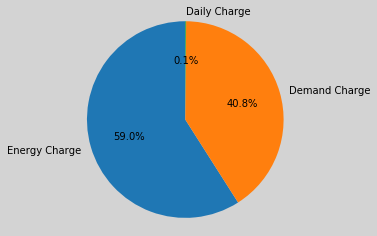

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 140, 235, 36, 56, 6, 0.7499999999999998, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


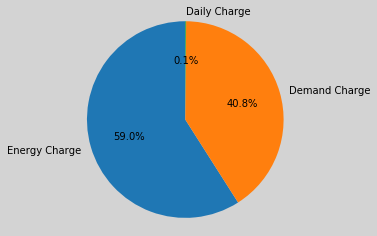

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 100, 230, 16, 21, 36, 0.7, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


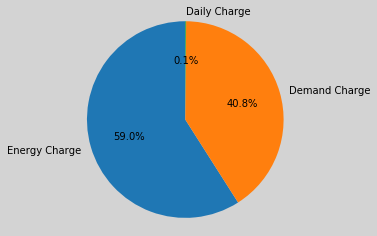

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 210, 195, 11, 26, 41, 0.39999999999999997, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


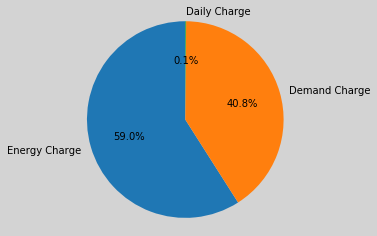

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 220, 125, 41, 11, 56, 0.8499999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


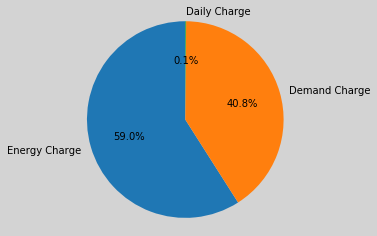

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (140, 165, 95, 36, 31, 11, 0.2, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.310689449310303 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


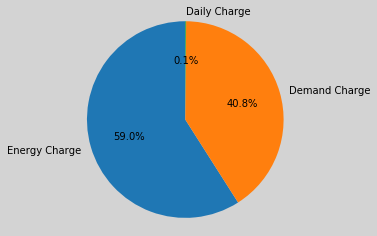

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 110, 90, 46, 16, 1, 0.7499999999999998, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.322480201721191 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


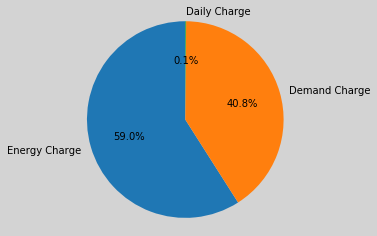

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (120, 230, 230, 46, 31, 51, 0.8499999999999999, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.648778915405273 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


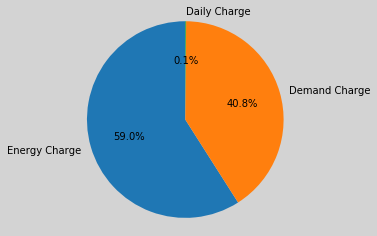

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 130, 260, 31, 36, 31, 0.5499999999999999, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


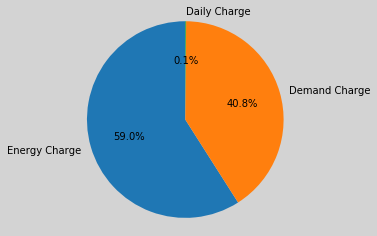

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 205, 100, 46, 16, 16, 0.8499999999999999, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.365931034088135 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


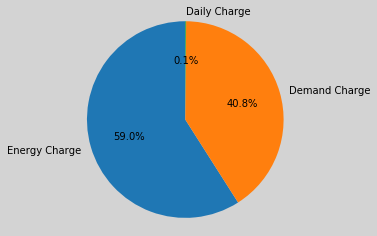

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 175, 140, 41, 56, 11, 0.39999999999999997, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


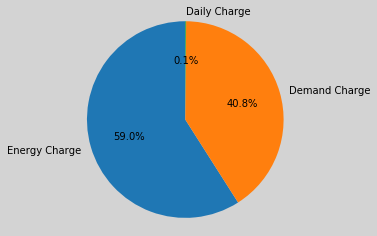

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 265, 225, 36, 1, 46, 0.39999999999999997, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


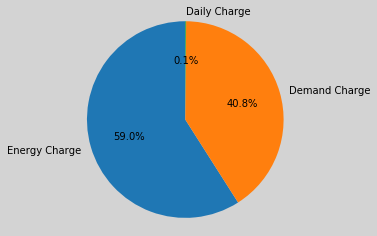

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 95, 255, 46, 6, 56, 0.5999999999999999, 0.2, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.104417562484741 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


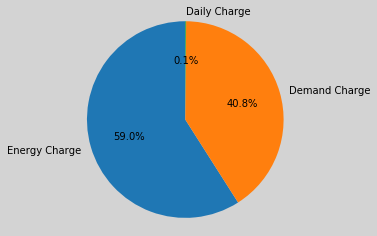

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (210, 140, 160, 41, 41, 11, 0.7, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.733696222305298 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


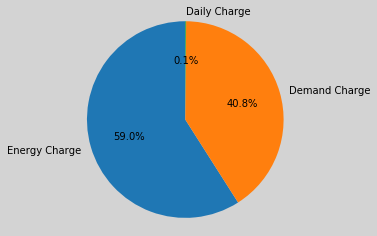

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (135, 110, 110, 56, 16, 16, 0.8999999999999999, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.157571077346802 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


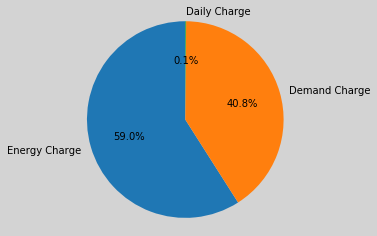

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (90, 225, 265, 51, 21, 46, 0.7999999999999998, 0.25, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


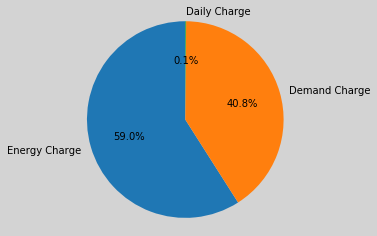

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (210, 145, 210, 26, 46, 26, 0.7, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


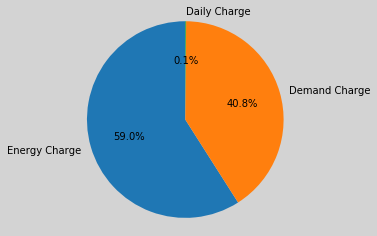

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 90, 145, 36, 1, 11, 0.3, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.554959774017334 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


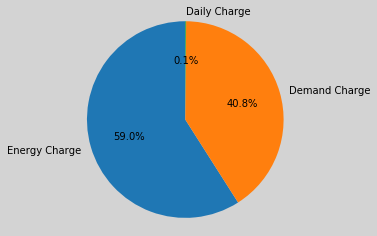

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 195, 95, 21, 46, 31, 0.35, 0.35, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.429900646209717 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


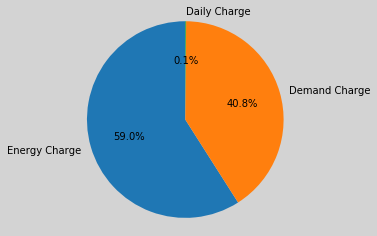

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 215, 100, 51, 26, 6, 0.7, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.110296010971069 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


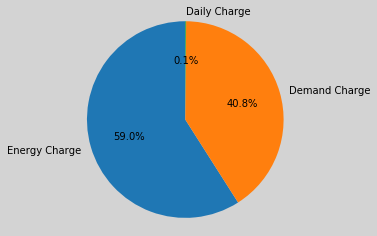

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 180, 170, 36, 1, 36, 0.35, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


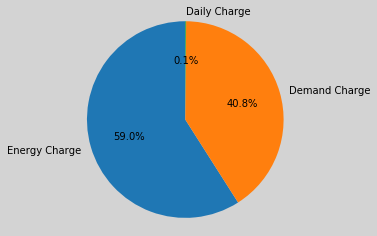

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 255, 125, 36, 31, 1, 0.7, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.322492361068726 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


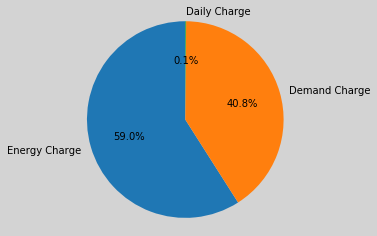

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (235, 190, 245, 56, 1, 26, 0.3, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.01672887802124 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.892030477523804 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


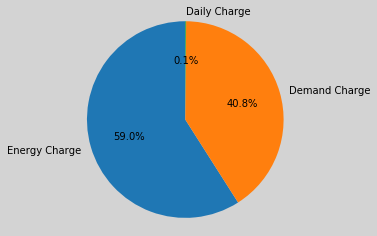

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 175, 195, 46, 11, 31, 0.44999999999999996, 0.2, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.537480592727661 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


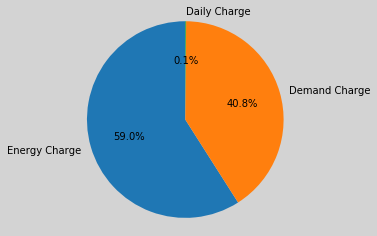

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (95, 150, 125, 31, 16, 46, 0.3, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.3629820346832275 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.556732892990112 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


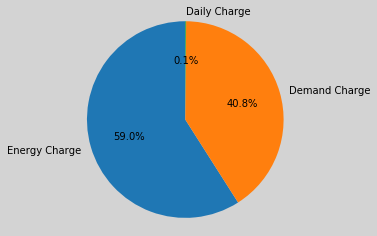

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (135, 225, 245, 11, 56, 16, 0.49999999999999994, 0.2, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


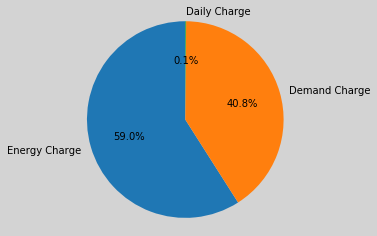

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (95, 150, 255, 6, 16, 21, 0.2, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


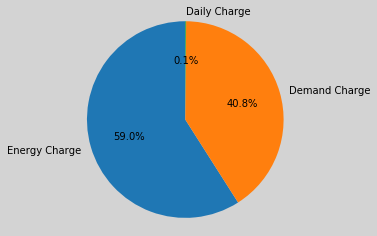

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 90, 205, 1, 1, 41, 0.35, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


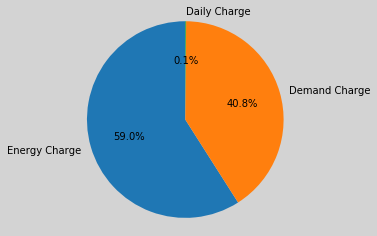

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 235, 260, 36, 1, 36, 0.49999999999999994, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


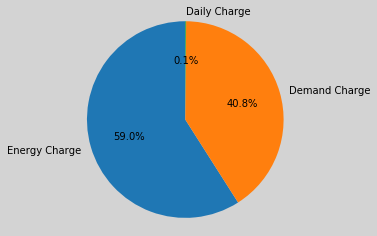

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (175, 205, 210, 56, 11, 41, 0.44999999999999996, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.281707525253296 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.953909873962402 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


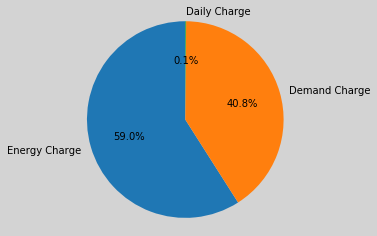

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (120, 165, 120, 46, 16, 31, 0.25, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.829308271408081 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


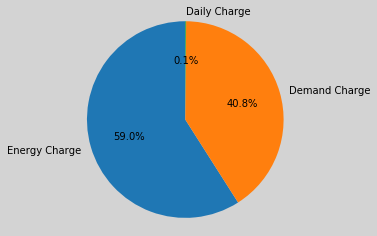

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 160, 240, 36, 46, 21, 0.5499999999999999, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


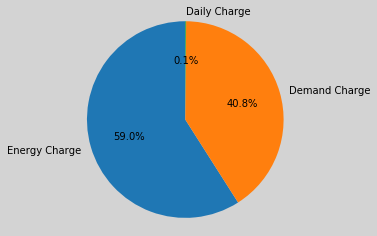

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 165, 220, 11, 11, 1, 0.8499999999999999, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.640936613082886 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 235, 165, 21, 31, 41, 0.44999999999999996, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


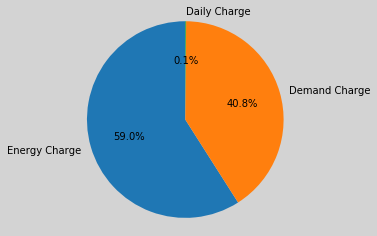

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 250, 165, 41, 56, 16, 0.44999999999999996, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.562447547912598 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


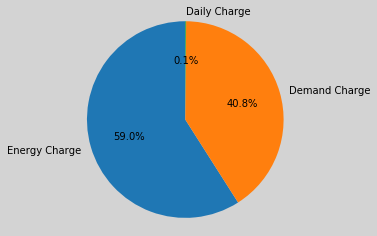

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 145, 240, 46, 51, 46, 0.2, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1394712924957275 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


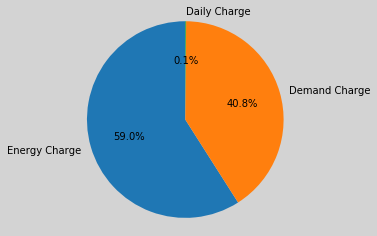

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (265, 110, 185, 41, 31, 51, 0.7999999999999998, 0.25, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


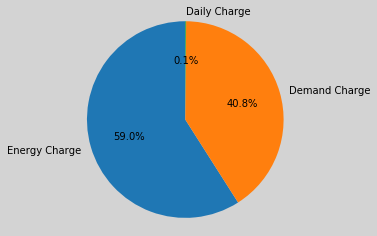

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 185, 175, 21, 51, 41, 0.35, 0.5999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.825381755828857 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


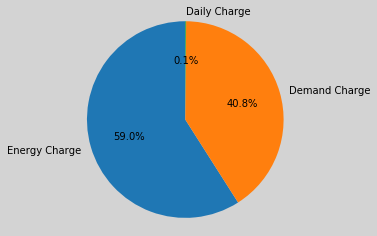

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (120, 215, 190, 46, 1, 6, 0.35, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


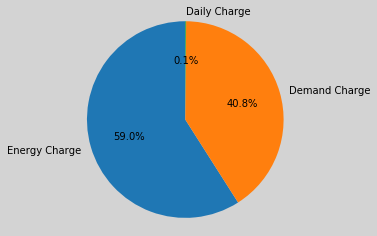

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 155, 245, 41, 36, 16, 0.35, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.986881971359253 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


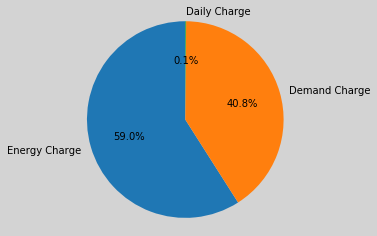

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (90, 240, 155, 36, 26, 31, 0.8499999999999999, 0.2, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.373597621917725 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


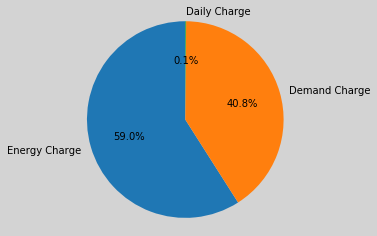

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (135, 135, 135, 41, 16, 31, 0.5499999999999999, 0.6499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.492446660995483 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


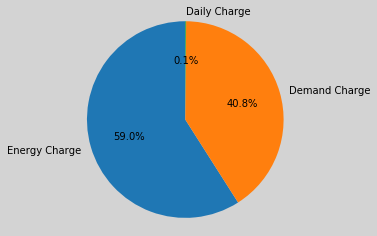

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 260, 170, 26, 36, 1, 0.35, 0.8499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.831254720687866 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


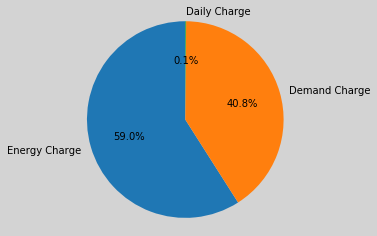

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (265, 235, 235, 21, 11, 26, 0.35, 0.25, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.217239618301392 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


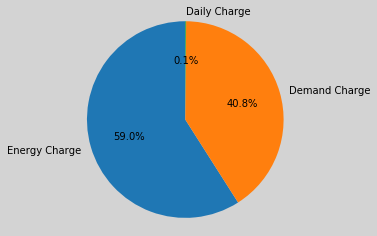

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 180, 90, 26, 41, 16, 0.2, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.387786626815796 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


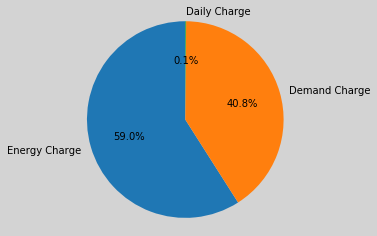

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 195, 165, 56, 36, 11, 0.39999999999999997, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


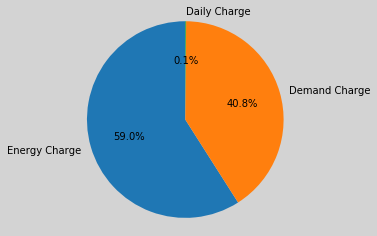

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 200, 120, 46, 41, 31, 0.2, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


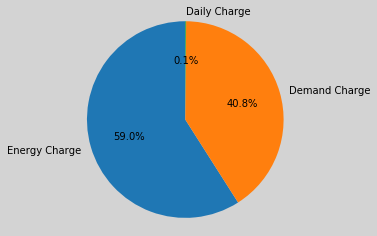

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 235, 215, 11, 11, 36, 0.8999999999999999, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


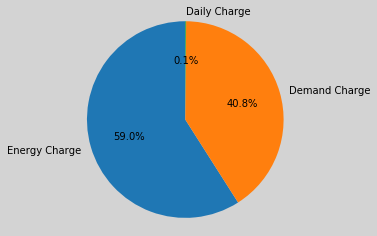

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (95, 150, 120, 16, 51, 26, 0.5999999999999999, 0.7, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


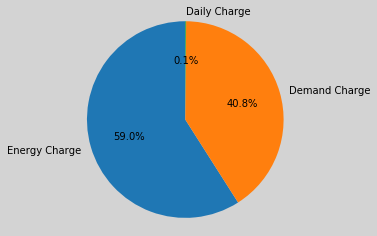

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (265, 170, 160, 1, 36, 31, 0.3, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


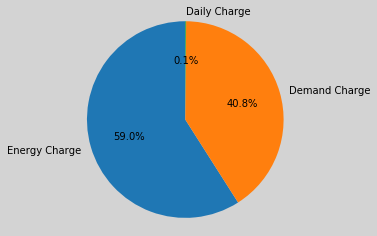

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (105, 105, 265, 26, 21, 31, 0.7999999999999998, 0.8499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


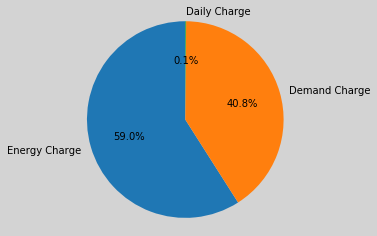

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 145, 140, 51, 26, 46, 0.35, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


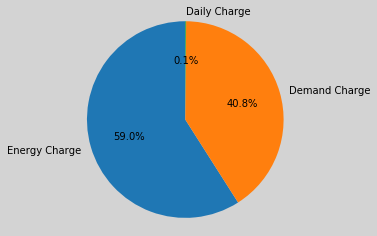

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (105, 205, 260, 46, 41, 51, 0.8999999999999999, 0.5999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


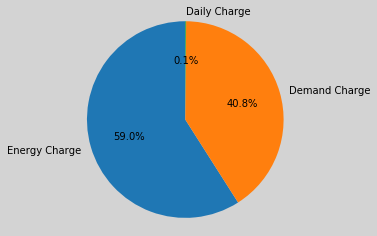

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 140, 260, 6, 36, 6, 0.39999999999999997, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


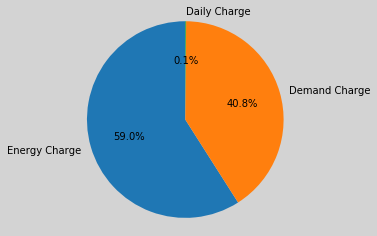

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 110, 190, 16, 21, 16, 0.8999999999999999, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.368123769760132 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.100805997848511 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


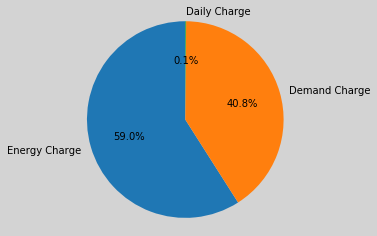

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (90, 225, 235, 6, 16, 51, 0.3, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


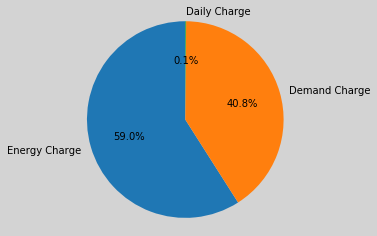

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (235, 245, 135, 6, 26, 31, 0.7499999999999998, 0.7999999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.62574052810669 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


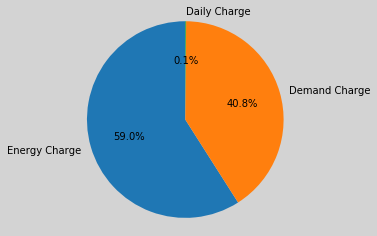

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (90, 265, 245, 11, 21, 16, 0.3, 0.7, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.897380828857422 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.5270466804504395 sec


ERROR:ga_logger:Generated the panel irradiance in  16s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


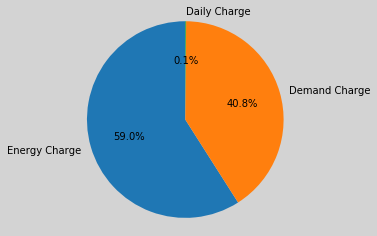

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 225, 245, 56, 1, 46, 0.3, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


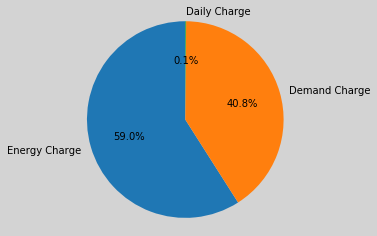

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (245, 165, 175, 11, 1, 16, 0.35, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.768527269363403 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


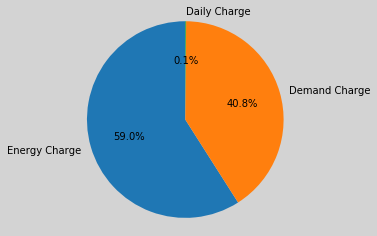

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (185, 145, 190, 41, 21, 11, 0.7999999999999998, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.830745458602905 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


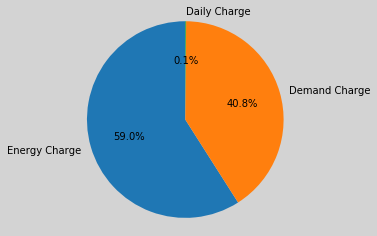

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 225, 105, 26, 11, 36, 0.39999999999999997, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.4481213092803955 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


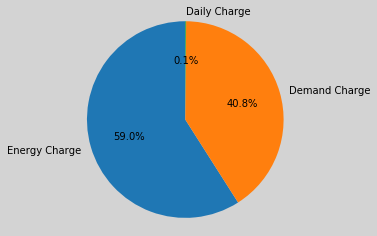

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (110, 200, 90, 16, 36, 51, 0.6499999999999999, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


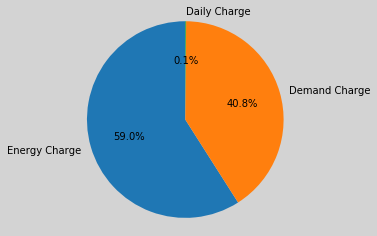

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (135, 140, 195, 26, 21, 26, 0.49999999999999994, 0.49999999999999994, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.402162790298462 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


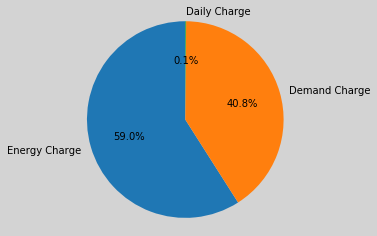

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 100, 90, 41, 6, 41, 0.6499999999999999, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


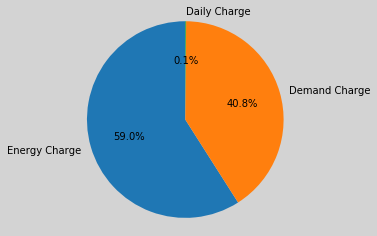

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 160, 195, 26, 51, 21, 0.2, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


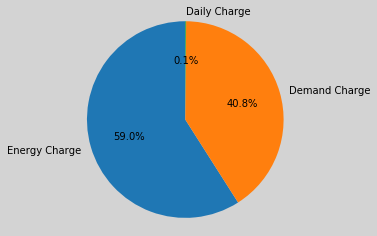

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (190, 115, 115, 21, 46, 36, 0.5999999999999999, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.968103885650635 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


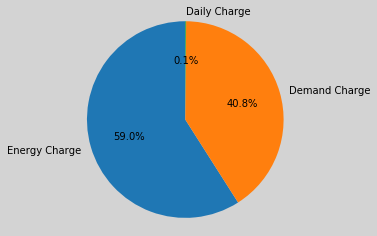

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (175, 200, 135, 31, 46, 1, 0.8499999999999999, 0.3, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


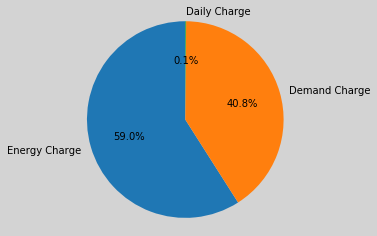

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 165, 215, 11, 31, 36, 0.35, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.181055068969727 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


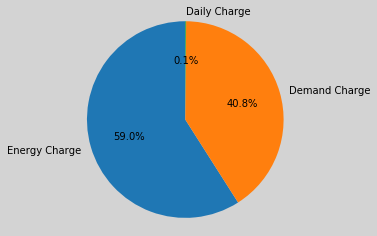

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 190, 130, 41, 46, 56, 0.7, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.192989110946655 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


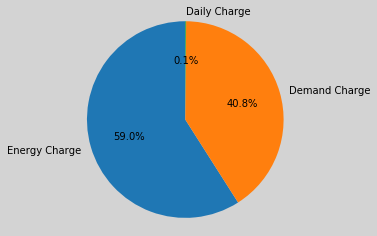

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (175, 145, 205, 26, 11, 36, 0.49999999999999994, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


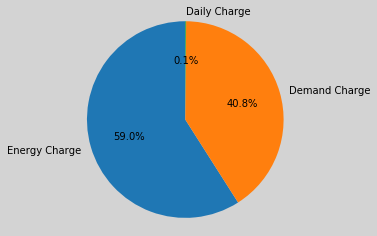

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 160, 145, 41, 16, 11, 0.25, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


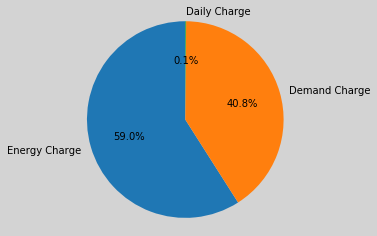

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 110, 210, 36, 31, 1, 0.7, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


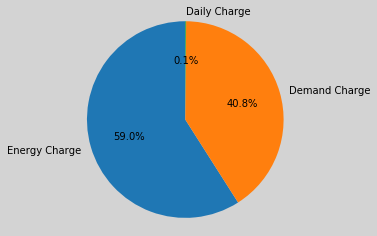

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (140, 125, 215, 16, 31, 16, 0.39999999999999997, 0.7499999999999998, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


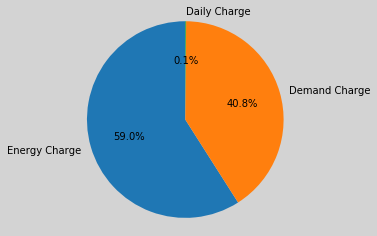

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 185, 225, 51, 46, 51, 0.5999999999999999, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.461529016494751 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


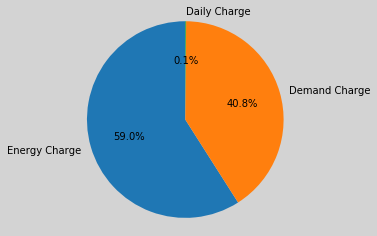

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 105, 205, 56, 26, 6, 0.6499999999999999, 0.3, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.687121629714966 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.942766189575195 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


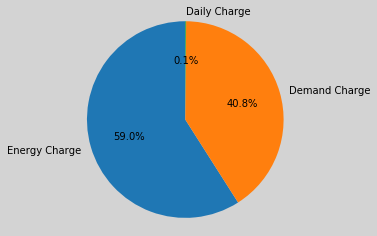

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (175, 105, 255, 46, 46, 31, 0.8499999999999999, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.614802122116089 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


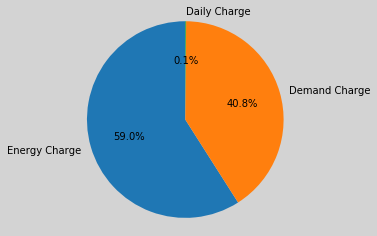

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 185, 220, 36, 31, 36, 0.7, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.60483980178833 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.962480545043945 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


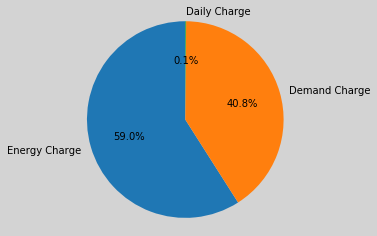

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 110, 235, 6, 46, 6, 0.49999999999999994, 0.7499999999999998, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.6450910568237305 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


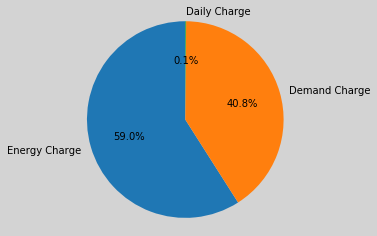

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (105, 245, 90, 36, 11, 56, 0.7499999999999998, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.2928125858306885 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


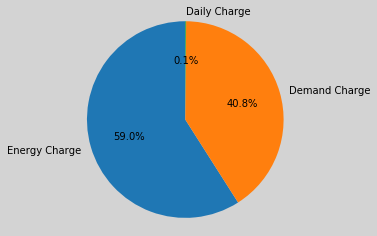

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (185, 155, 95, 26, 1, 21, 0.6499999999999999, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


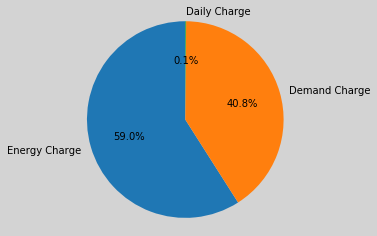

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (255, 195, 165, 46, 21, 6, 0.35, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


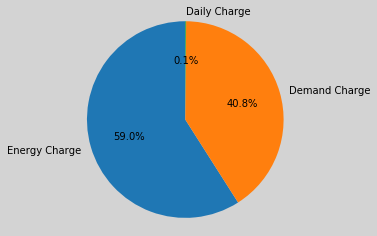

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1089: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
2
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      160
azi1      165
azi2      220
tilt0      11
tilt1      11
tilt2       1
gcr0     0.85
gcr1     0.55
gcr2     0.35
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


[[160, 165, 220, 11, 11, 1, 0.8499999999999999, 0.5499999999999999, 0.35, 80, 0, 0.0, 0.0, 0.0, 1, 'red', [0, 0, 0], 80, 80, 0]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      110
azi1      200
azi2       90
tilt0      16
tilt1      36
tilt2      51
gcr0     0.65
gcr1     0.35
gcr2      0.8
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


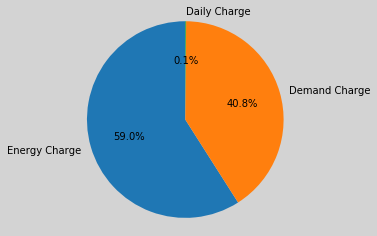

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%
[[110, 200, 90, 16, 36, 51, 0.6499999999999999, 0.35, 0.7999999999999998, 71422.1, 0.0, 0.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 0.07550000000669854, 'Energy Charge': 42154.61, 'Demand Charge': 29169.85, 'Daily Charge': 97.5645}, 0.0, 695621.0, 0.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)